# Image Exploration on AWS

*By Danny Luo*

The following notebook is a brief exploration of satellite images for the DSTL Satellite Image Feature Detection on Kaggle.

Modified for AWS from *Cem Anil's* image exploration notebook. Cem and Danny are members of the University of Toronto Data Science Team (UDST). We do Kaggle competitions.

### Libraries

In [2]:
%matplotlib inline
import os
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image #Using Pillow for Py3
import tifffile as tiff
import shapely

from IPython.display import display, HTML
from io import BytesIO

### AWS
Setting up AWS connection with boto3 AWS SDK. You should first run `aws configure` in your instance terminal (with aws cli installed) to set up the appropiate credentials.

In [3]:
import boto3
#Let's use Amazon S3

client = boto3.client('s3') #functional oriented API
resource = boto3.resource('s3') #object oriented API
udst_dstl =resource.Bucket('udst-dstl') #subsitute this for your s3 bucket where you keep your data.

Retrieving `grid_sizes.csv` from AWS and importing as pandas data table. Pandas is good here because it can read directly from the `obj['Body']` which is a `StreamingBody` object, a data stream, whose contants can be viewed by `obj['Body'].read()`.

In [4]:
#I assume the original file hierachy of the dstl files is unchanged.

obj = client.get_object(Bucket='udst-dstl', Key='data/grid_sizes.csv')
grid_sizes = pd.read_csv(obj['Body'])
display(grid_sizes)

,Unnamed: 0,Xmax,Ymin
0,6120_2_4,0.009180,-0.009040
1,6120_2_3,0.009169,-0.009040
2,6120_2_2,0.009188,-0.009040
3,6120_2_1,0.009188,-0.009040
4,6120_2_0,0.009188,-0.009040
5,6180_2_4,0.009169,-0.009031
6,6180_2_1,0.009169,-0.009042
7,6180_2_0,0.009156,-0.009042
8,6180_2_3,0.009188,-0.009040
9,6180_2_2,0.009188,-0.009040


Here we retrieve a list of names of sixteen_band images, with relevant metadata, and stick it into a pandas Dataframe.

Currently, this query has a maximum of 1000 objects.

In [5]:
obj_list = client.list_objects(Bucket='udst-dstl', Prefix='data/sixteen_band/')

print('Is the result truncated: ', obj_list['IsTruncated']) #If there is more than 1000 objects, this will be true.

image_metadata = pd.DataFrame.from_dict(obj_list['Contents'])
display(image_metadata)

Is the result truncated:  True


,ETag,Key,LastModified,Owner,Size,StorageClass
0,"""bf95119be1369cc706ec998eacb8e00d""",data/sixteen_band/6010_0_0_A.tif,2017-01-23 04:39:24+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",292136,STANDARD
1,"""2142dafb1455ab48e340dfff00e88523-2""",data/sixteen_band/6010_0_0_M.tif,2017-01-23 04:39:24+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",11370736,STANDARD
2,"""a5fa48390dc53fff5f81f86a09970fc0-3""",data/sixteen_band/6010_0_0_P.tif,2017-01-23 04:39:25+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",22740857,STANDARD
3,"""aef37141d9f26568c864e20a0f21d043""",data/sixteen_band/6010_0_1_A.tif,2017-01-23 04:39:25+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",292136,STANDARD
4,"""2f474b38c4675e8047eb3de5f9cfd9a7-2""",data/sixteen_band/6010_0_1_M.tif,2017-01-23 04:39:25+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",11370736,STANDARD
5,"""56cbf3a23ef3d97340d7f5db700e1b4a-3""",data/sixteen_band/6010_0_1_P.tif,2017-01-23 04:39:25+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",22740857,STANDARD
6,"""cf4bd970ca4d5f616bb52c39c666115d""",data/sixteen_band/6010_0_2_A.tif,2017-01-23 04:39:25+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",292136,STANDARD
7,"""052ab800708494564656fed6f638fcb5-2""",data/sixteen_band/6010_0_2_M.tif,2017-01-23 04:39:25+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",11370736,STANDARD
8,"""47b745024d77ba40a6673be9a3a073de-3""",data/sixteen_band/6010_0_2_P.tif,2017-01-23 04:39:25+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",22740857,STANDARD
9,"""461bf6d205194d0a0bb98fc6f801f1a3""",data/sixteen_band/6010_0_3_A.tif,2017-01-23 04:39:25+00:00,"{'DisplayName': 'luoxiao96', 'ID': 'c9e1f0fe4f...",292136,STANDARD


To access all the objects, we can iterate over the bucket object.

In [23]:
#Getting a list of all band_16_meta data, 

band_16_images = list(udst_dstl.objects.filter(Prefix='data/sixteen_band')) #list of individual ObjectSummary's
band_3_images = list(udst_dstl.objects.filter(Prefix='data/three_band'))

print(band_16_images[0]) #each entry is an s3.ObjectSummary object
print(band_3_images[0])

s3.ObjectSummary(bucket_name='udst-dstl', key='data/sixteen_band/6010_0_0_A.tif')
s3.ObjectSummary(bucket_name='udst-dstl', key='data/three_band/6010_0_0.tif')


#### Image Files

In [7]:
# 16 Band images
band_16_A_images = []
band_16_M_images = []
band_16_P_images = []
for i in range(len(band_16_images)):
    id_letter = band_16_images[i].key.split('.')[0][-1]
    if id_letter == 'A':
        band_16_A_images.append(band_16_images[i])
    elif id_letter == 'M':
        band_16_M_images.append(band_16_images[i])
    elif id_letter == 'P':
        band_16_P_images.append(band_16_images[i])
    else:
        raise Exception('Unidentified ID Letter: ', band_16_images[i].key)

## Quick survey on image sizes and numbers

In [29]:
# No of 3 band images:
print('No of 3-band images: ', len(band_3_images))
# No of 16 band images:
print( 'No of 16-band images: ', len(band_16_images), '/ (3 filters)  = ', int(len(band_16_images)/3))

No of 3-band images:  450
No of 16-band images:  1350 / (3 filters)  =  450


In [28]:
# Image dimensions of 3-band images

band_3_image_sizes = []
for i in range(len(band_3_images)):
    band_3_image_sample = tiff.imread(BytesIO(band_3_images[i].get()['Body'].read()))
    band_3_image_sizes.append(band_3_image_sample.shape)
    if i % 100 == 0:
        print(i, ' / ', len(band_3_images), ' read.')
# Different image dimensions in 3-band images
band_3_image_sizes_set = set(band_3_image_sizes)
print('Different dimensions in band-3 images')
band_3_image_sizes_set

0  /  450  read.
100  /  450  read.
200  /  450  read.
300  /  450  read.
400  /  450  read.
Different dimensions in band-3 images


{(3, 3345, 3389),
 (3, 3345, 3390),
 (3, 3345, 3391),
 (3, 3345, 3393),
 (3, 3345, 3395),
 (3, 3345, 3396),
 (3, 3346, 3335),
 (3, 3346, 3338),
 (3, 3346, 3387),
 (3, 3346, 3391),
 (3, 3347, 3335),
 (3, 3347, 3336),
 (3, 3347, 3338),
 (3, 3347, 3339),
 (3, 3348, 3393),
 (3, 3348, 3396),
 (3, 3348, 3400),
 (3, 3348, 3403),
 (3, 3349, 3387),
 (3, 3349, 3389),
 (3, 3349, 3390),
 (3, 3349, 3391),
 (3, 3349, 3393),
 (3, 3349, 3395),
 (3, 3349, 3396),
 (3, 3350, 3335),
 (3, 3350, 3336),
 (3, 3350, 3338),
 (3, 3350, 3339)}

In [15]:
# Surveying 16-band *_.A image sizes

image_sizes_A = []
for i in range(len(band_16_A_images)):
    band_16_image_sample_A = tiff.imread(BytesIO(band_16_A_images[i].get()['Body'].read()))
    image_sizes_A.append(band_16_image_sample_A.shape)
    if i % 100 == 0:
        print(i, ' / ', len(band_16_A_images), ' read.')
image_sizes_A_set = set(image_sizes_A)
print('Different dimensions in band-16-A images')
image_sizes_A_set

0  /  450  read.
100  /  450  read.
200  /  450  read.
300  /  450  read.
400  /  450  read.
Different dimensions in band-16-A images


{(8, 133, 132),
 (8, 133, 133),
 (8, 133, 134),
 (8, 133, 135),
 (8, 133, 136),
 (8, 133, 137),
 (8, 134, 132),
 (8, 134, 133),
 (8, 134, 134),
 (8, 134, 135),
 (8, 134, 136),
 (8, 134, 137)}

In [16]:
# Surveying 16-band *_.M image sizes

image_sizes_M = []
for i in range(len(band_16_M_images)):
    band_16_image_sample_M = tiff.imread(BytesIO(band_16_M_images[i].get()['Body'].read()))
    image_sizes_M.append(band_16_image_sample_M.shape)
    if i % 100 == 0:
        print(i, ' / ', len(band_16_M_images), ' read.')
image_sizes_M_set = set(image_sizes_M)
print('Different dimensions in band-16-M images')
image_sizes_M_set

0  /  450  read.
100  /  450  read.
200  /  450  read.
300  /  450  read.
400  /  450  read.
Different dimensions in band-16-M images


{(8, 834, 832),
 (8, 834, 835),
 (8, 835, 831),
 (8, 835, 833),
 (8, 835, 835),
 (8, 837, 846),
 (8, 837, 847),
 (8, 837, 848),
 (8, 837, 849),
 (8, 837, 850),
 (8, 837, 851),
 (8, 838, 831),
 (8, 838, 832),
 (8, 838, 833),
 (8, 838, 835)}

In [17]:
# Surveying 16-band *_.P image sizes
image_sizes_P = []
for i in range(len(band_16_P_images)):
    band_16_image_sample_P = tiff.imread(BytesIO(band_16_P_images[i].get()['Body'].read()))
    image_sizes_P.append(band_16_image_sample_P.shape)
    if i % 100 == 0:
        print(i, ' / ', len(band_16_M_images), ' read.')
image_sizes_P_set = set(image_sizes_P)
print('Different dimensions in band-16-P images')
image_sizes_P_set

0  /  450  read.
100  /  450  read.
200  /  450  read.
300  /  450  read.
400  /  450  read.
Different dimensions in band-16-P images


{(3348, 3336),
 (3348, 3337),
 (3348, 3338),
 (3348, 3339),
 (3348, 3388),
 (3348, 3391),
 (3348, 3392),
 (3348, 3395),
 (3348, 3396),
 (3348, 3400),
 (3348, 3403),
 (3348, 3404),
 (3349, 3336),
 (3349, 3338),
 (3350, 3336),
 (3350, 3337),
 (3350, 3339)}

## View 3-band images

The following commands are done functionally with the client API but may also be easily done with the above object API.

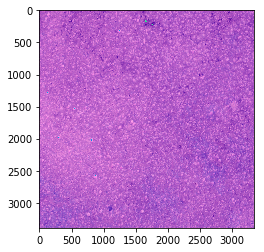

In [19]:
# 3 channels simultaneously, using client API
band_3_sample = 'data/three_band/6180_4_4.tif'
obj = client.get_object(Bucket='udst-dstl', Key=band_3_sample)
band_3_image_sample = tiff.imread(BytesIO(obj['Body'].read()))

plt.figure(0)
plt.imshow(band_3_image_sample.T)

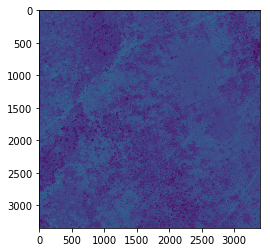

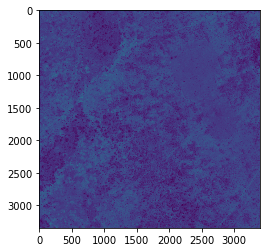

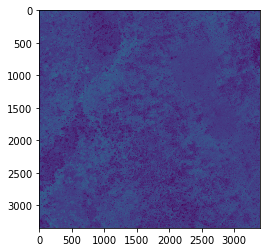

In [24]:
# 3 channels separate, using object API
band_3_image_sample = tiff.imread(BytesIO(band_3_images[0].get()['Body'].read()))
for i in range(band_3_image_sample.shape[0]):
    plt.figure(i)
    plt.imshow(band_3_image_sample[i,:,:])

## View 16-band Images

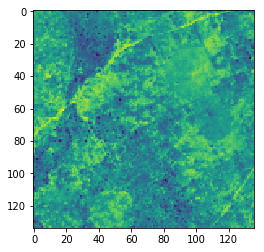

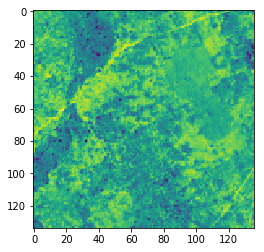

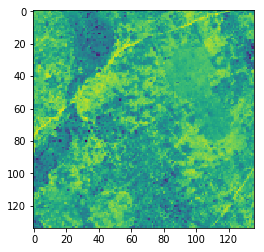

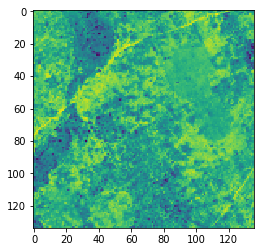

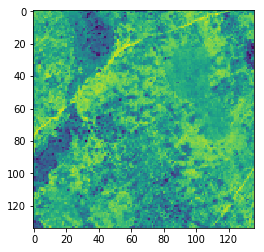

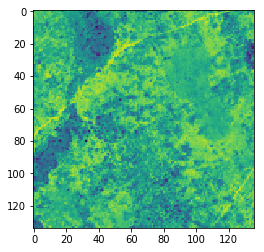

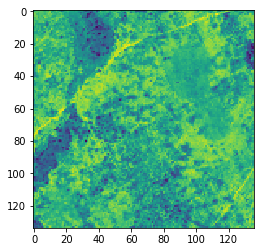

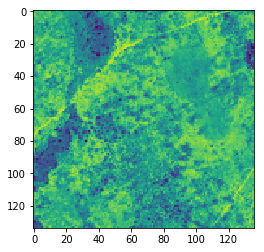

In [25]:
# View the *_A files
band_16_A_sample = 'data/sixteen_band/6010_0_0_A.tif'
obj = client.get_object(Bucket='udst-dstl', Key=band_16_A_sample)
band_16_A_image_sample = tiff.imread(BytesIO(obj['Body'].read()))
for i in range(len(band_16_A_image_sample[:,0,0])):
    fig = plt.figure(i)
    plt.imshow(band_16_A_image_sample[i,:,:])

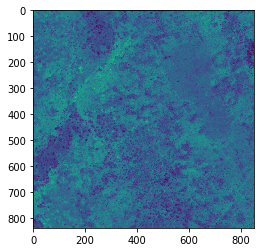

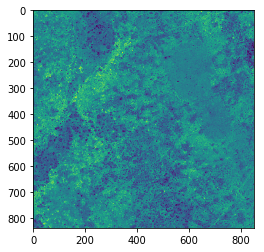

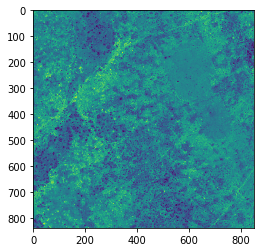

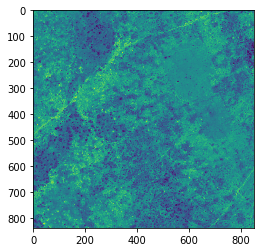

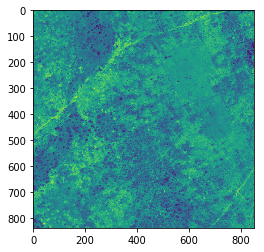

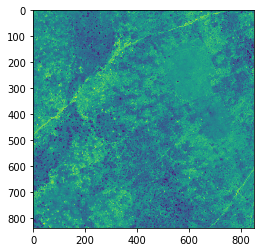

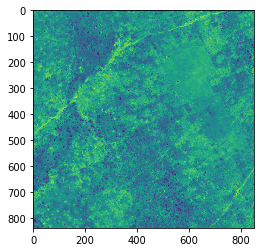

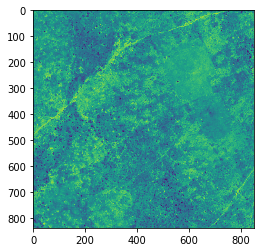

In [26]:
# View the *_M files
#image_sample = os.path.join(data_dir, 'sixteen_band','6010_0_0_M.tif')
obj = client.get_object(Bucket='udst-dstl', Key='data/sixteen_band/6010_0_0_M.tif')
P = tiff.imread(BytesIO(obj['Body'].read()))

a = 0
for i in range(len(P[:,0,0])):
    fig = plt.figure(i)
    plt.imshow(P[i,:,:])

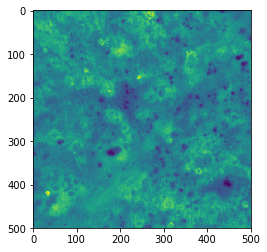

In [27]:
# View the *_P files
obj = client.get_object(Bucket='udst-dstl', Key='data/sixteen_band/6010_0_0_P.tif')
P = tiff.imread(BytesIO(obj['Body'].read()))

plt.figure(0)
plt.imshow(P[0:500, 0:500])